In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src import train, generate, eval
from src.train import make_inference_model
from src.pipeline_util import load_bnn
from src.modules.config import read_config
import src.modules.plots as plots
from src.modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "./configs/likelihood-over-underfit"
PROFILE = "fixed-small"

#BASE_DIR = "../tests/dataset-tests/sineasy10-10k-s05/"
#PROFILE = "sineasy10-3x128-s05"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [5]:
if not os.path.exists(BASE_DIR + "/plots"):
    os.makedirs(BASE_DIR + "/plots")


sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

====== Generating profile sin-tiny ======
Train: (-4, 4)
Y-space: -1.3424362096681117 - 1.4884028211764229
In Domain: (-4, 4)
Y-space: -1.5050772375038213 - 1.5588537323018117
Out Domain: (-6, 6)
Y-space: -1.8493026811532731 - 1.7584319841239946


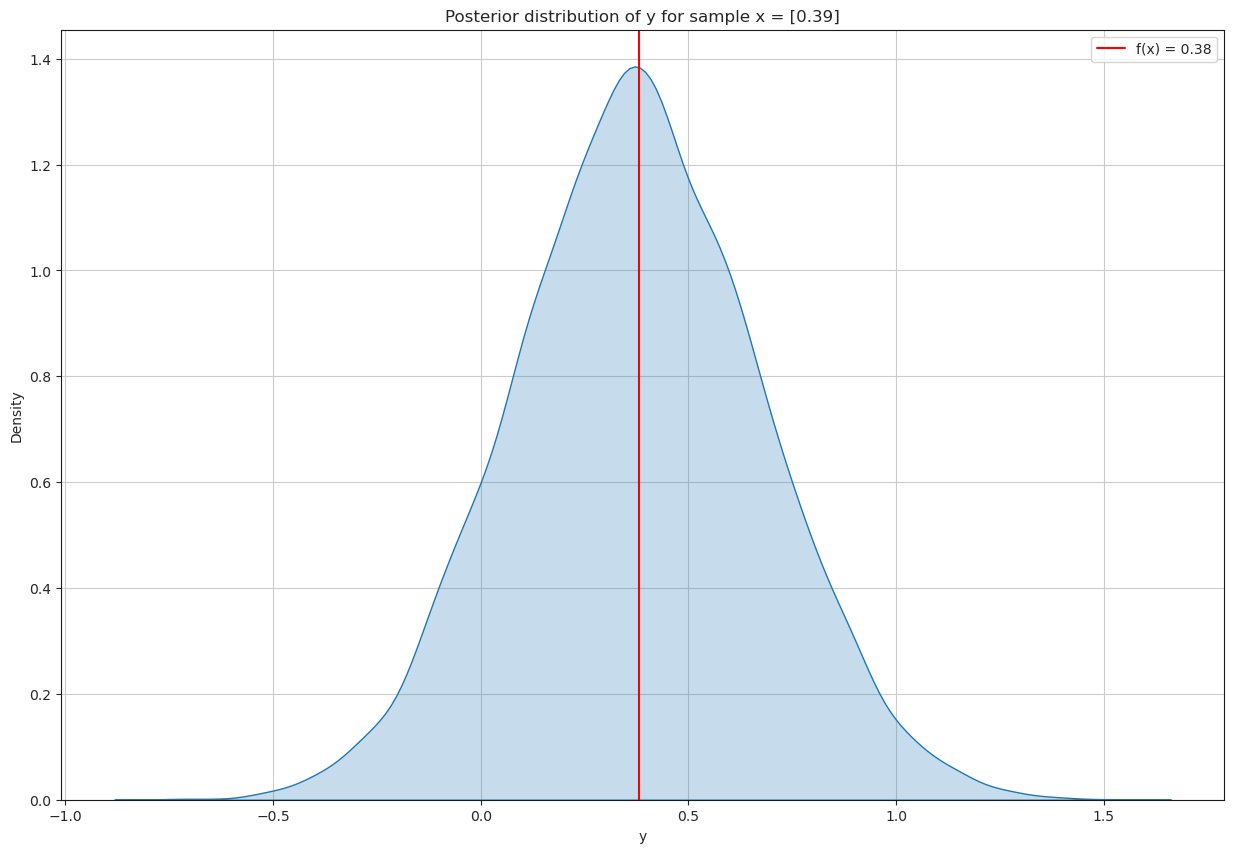

In [6]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [7]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([400, 1]) torch.Size([400, 1])


In [8]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([400, 1]) torch.Size([400, 1])


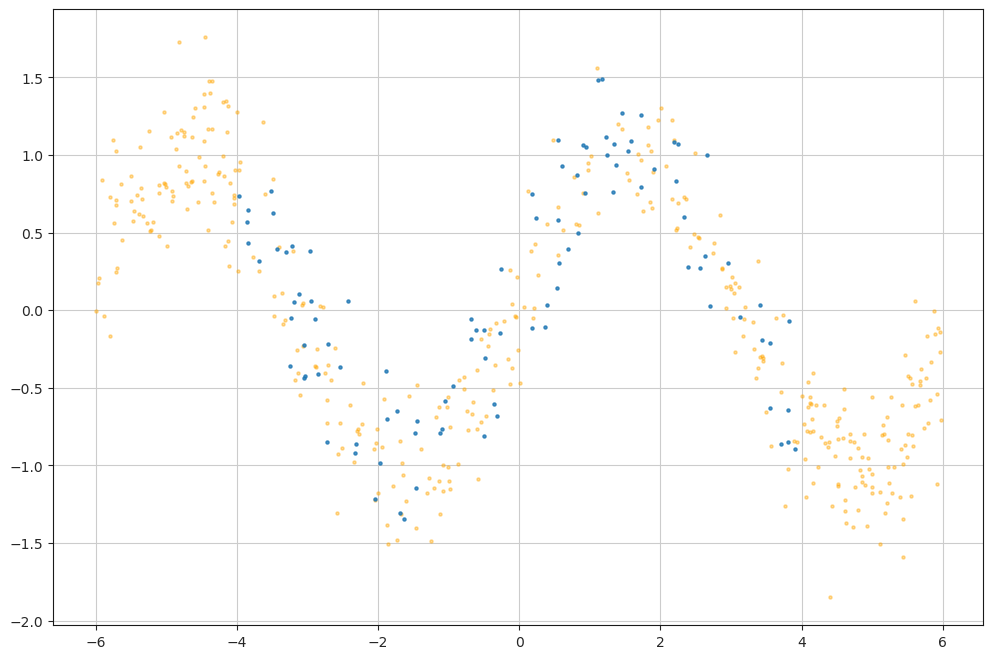

In [9]:
if dataset_config["X_DIM"] == "1":
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.scatter(x_test.squeeze(), y_test, color="orange", s=5, alpha=0.4)
    plt.scatter(x_train.squeeze(), y_train, s=5, alpha=0.8)


In [10]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

torch.Size([100, 1]) torch.Size([100, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.03 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Using device: cpu
===== Training profile fixed-small - 1 =====
[0:00:00.640901] epoch: 0 | elbo: 912187.3375 | train_rmse: 3.0662 | val_rmse: 3.5048 | val_ll: -3319.4529
[0:00:24.884879] epoch: 50 | elbo: 122809.5671875 | train_rmse: 0.4905 | val_rmse: 0.4742 | val_ll: -67.7267
[0:00:48.601408] epoch: 100 | elbo: 113618.73593750001 | train_rmse: 0.3132 | val_rmse: 0.3559 | val_ll: -42.2533
[0:01:12.742107] epoch: 150 | elbo: 111766.440625 | train_rmse: 0.2905 | val_rmse: 0.339 | val_ll: -37.4969
[0:01:36.597610] epoch: 200 | elbo: 110605.37343749999 | train_rmse: 0.2831 | val_rmse: 0.3369 | val_ll: -36.313
[0:02:00.591869] epoch: 250 | elbo: 109718.66406250001 | train_rmse: 0.2787 | val_rmse: 0.3401 | val_ll: -36.5695
[0:02:24.179832] epoch: 300 | elbo: 108733.6593

In [11]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt", device=config["DEVICE"])

Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.03 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Loaded SVI model from ./configs/likelihood-over-underfit/models/fixed-small/checkpoint_1.pt


In [12]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort].to(config["DEVICE"]), num_predictions=1000, aggregate=True)
p = bnn.predict(x_test[test_sort].to(config["DEVICE"]), num_predictions=1000, aggregate=False)

In [13]:
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

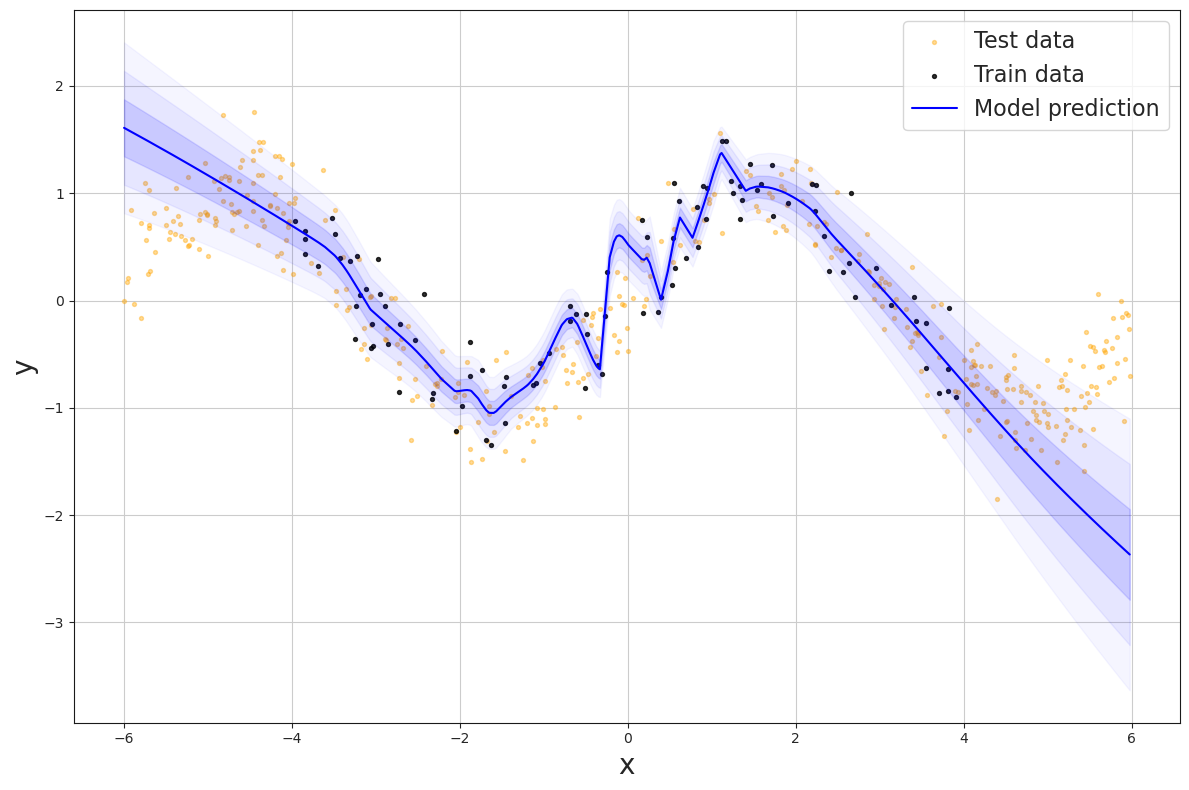

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=15, alpha=0.4, label="Test data")
plt.scatter(x_train, y_train, color="black", s=15, alpha=0.8, label="Train data")
plt.plot(x_test[test_sort], means, color="blue", label="Model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)

plt.tight_layout()
plt.legend(fontsize=20)
plt.savefig(f"{BASE_DIR}/plots/{NAME}.svg", format="svg", dpi=1200)
plt.show()

In [15]:
#### FIXED Correct

In [16]:
PROFILE = "fixed-correct"

In [17]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [18]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

torch.Size([100, 1]) torch.Size([100, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Using device: cpu
===== Training profile fixed-correct - 1 =====
[0:00:00.474910] epoch: 0 | elbo: 117972.9765625 | train_rmse: 3.0662 | val_rmse: 3.5048 | val_ll: -67.1065
[0:00:24.420974] epoch: 50 | elbo: 109140.82500000001 | train_rmse: 0.4895 | val_rmse: 0.4739 | val_ll: -0.9539
[0:00:47.706578] epoch: 100 | elbo: 108128.953125 | train_rmse: 0.3135 | val_rmse: 0.3567 | val_ll: -0.4205
[0:01:10.979781] epoch: 150 | elbo: 107205.421875 | train_rmse: 0.2913 | val_rmse: 0.3388 | val_ll: -0.3517
[0:01:34.168048] epoch: 200 | elbo: 106300.55625 | train_rmse: 0.2832 | val_rmse: 0.3352 | val_ll: -0.3384
[0:01:57.709291] epoch: 250 | elbo: 105407.8375 | train_rmse: 0.279 | val_rmse: 0.3377 | val_ll: -0.3476
[0:02:20.936576] epoch: 300 | elbo: 104521.51875 | train_rmse: 

In [19]:
bnn2 = make_inference_model(config, dataset_config)
bnn2 = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt", device=config["DEVICE"])

Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Loaded SVI model from ./configs/likelihood-over-underfit/models/fixed-correct/checkpoint_1.pt


In [20]:
test_sort = torch.argsort(x_test.squeeze())
preds2 = bnn2.predict(x_test[test_sort].to(config["DEVICE"]), num_predictions=1000, aggregate=True)

In [21]:
means, stds = preds2
means, stds = means.detach().cpu(), stds.detach().cpu()

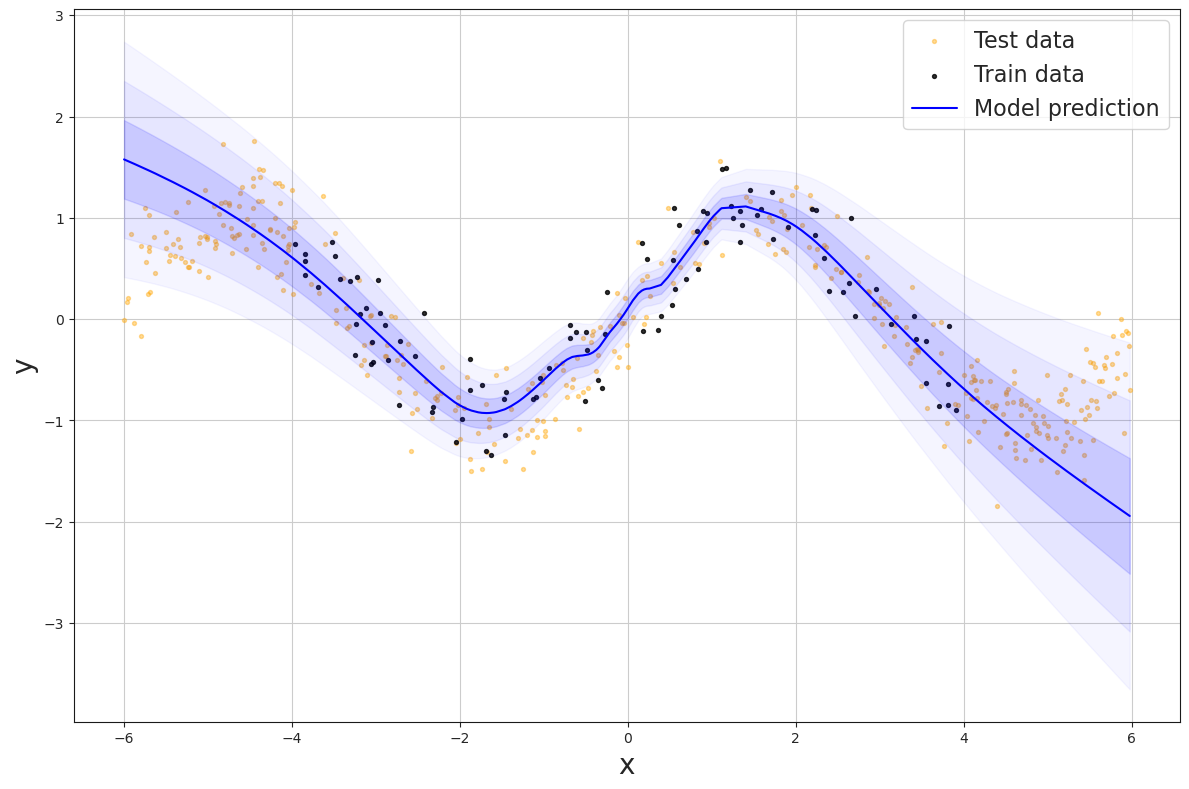

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=15, alpha=0.4, label="Test data")
plt.scatter(x_train, y_train, color="black", s=15, alpha=0.8, label="Train data")
plt.plot(x_test[test_sort], means, color="blue", label="Model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)

plt.tight_layout()
plt.legend( fontsize=20)
plt.savefig(f"{BASE_DIR}/plots/{NAME}.svg", format="svg", dpi=1200)
plt.show()

In [10]:
#### Fixed 

In [11]:
PROFILE = "fixed-large"

In [12]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [13]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"))

torch.Size([100, 1]) torch.Size([100, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 3.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Using device: cpu
===== Training profile fixed-large - 1 =====
[0:00:00.489750] epoch: 0 | elbo: 110258.79062500001 | train_rmse: 3.0715 | val_rmse: 3.5106 | val_ll: -2.7022
[0:00:24.717561] epoch: 50 | elbo: 109180.45625 | train_rmse: 0.5186 | val_rmse: 0.482 | val_ll: -2.0305
[0:00:48.435356] epoch: 100 | elbo: 108199.26250000001 | train_rmse: 0.3637 | val_rmse: 0.4232 | val_ll: -2.0275
[0:01:12.321469] epoch: 150 | elbo: 107241.4609375 | train_rmse: 0.3375 | val_rmse: 0.3906 | val_ll: -2.0261
[0:01:36.880226] epoch: 200 | elbo: 106303.03749999999 | train_rmse: 0.341 | val_rmse: 0.4062 | val_ll: -2.0267
[0:02:00.951753] epoch: 250 | elbo: 105380.4546875 | train_rmse: 0.3494 | val_rmse: 0.4154 | val_ll: -2.0272
[0:02:24.753077] epoch: 300 | elbo: 104470.75 | train_

In [15]:
bnn = make_inference_model(config, dataset_config)
bnn = load_bnn(bnn, config, f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt", device=config["DEVICE"])

Settings:
DEVICE: cpu INFERENCE_TYPE: svi OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 3.0 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Loaded SVI model from ./configs/likelihood-over-underfit/models/fixed-large/checkpoint_1.pt


In [20]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort].to(config["DEVICE"]), num_predictions=1000, aggregate=True)

In [21]:
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

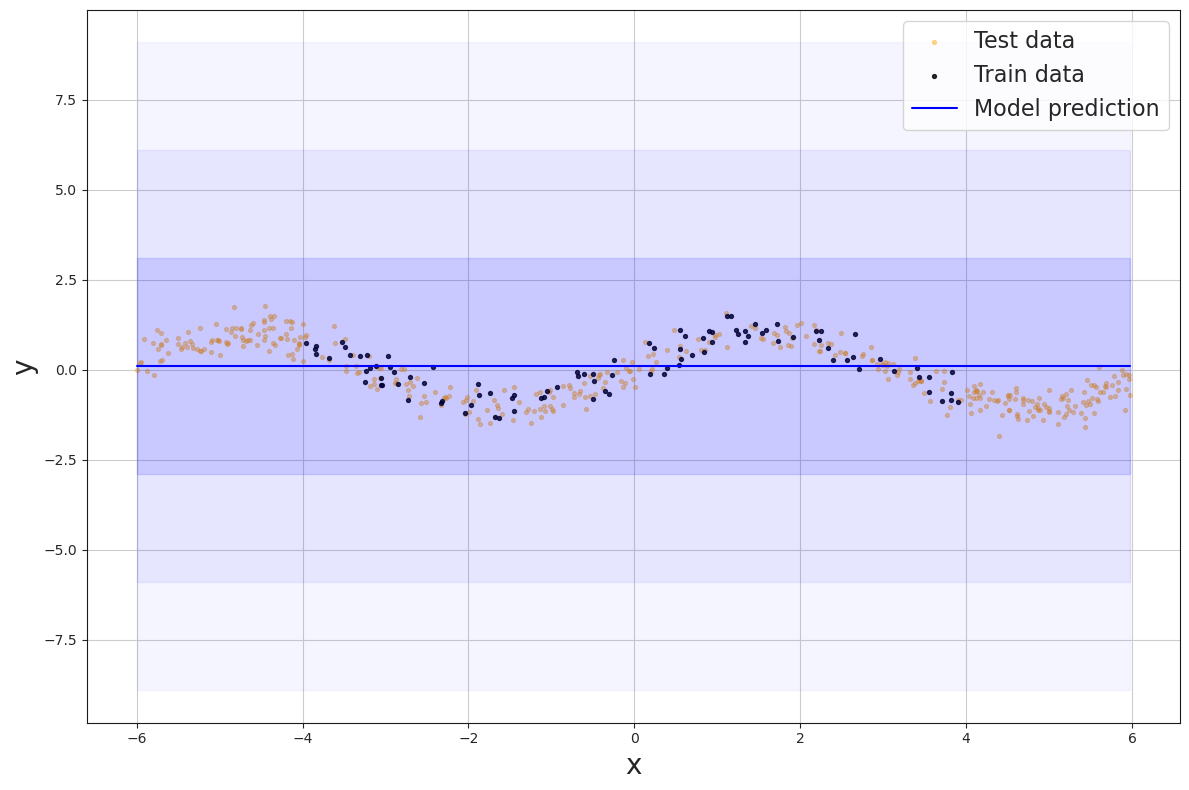

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=15, alpha=0.4, label="Test data")
plt.scatter(x_train, y_train, color="black", s=15, alpha=0.8, label="Train data")
plt.plot(x_test[test_sort], means, color="blue", label="Model prediction")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("y", fontsize=25)

plt.tight_layout()
plt.legend( fontsize=20)
plt.savefig(f"{BASE_DIR}/plots/{NAME}.svg", format="svg", dpi=1200)
plt.show()